In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=c6e6608a79792aabd0206a59df238d37fbee8d43474faf17994ed5c211384e37
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
import torch
import pickle
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import networkx as nx
import pandas as pd
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric import utils
from torch_geometric.nn import GCNConv, GATConv, GraphConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from itertools import count
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

I. Read the adjacency list into NetworkX, then attach attributes to the networkX graph.


In [ ]:
social_graph = nx.read_adjlist('ch3_data/adjacency_list_test.txt')

node_attr = pd.read_csv('ch3_data/node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr = node_attr.set_index('hashedid')
attribute_dict = node_attr.to_dict(orient='index')

nx.set_node_attributes(social_graph, attribute_dict)

Since the graph is disconnected, we select the largest connected component.

For visualization purposes, we create a color mapping from the job_type attribute.

In [ ]:
sub_graph = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])

groups = set(nx.get_node_attributes(sub_graph,'company_type').values())

adj_matrix_sparse = nx.adjacency_matrix(sub_graph)
adj_matrix_dense = adj_matrix_sparse.toarray()

# If you want it as a NumPy matrix
adj_true = torch.tensor(adj_matrix_dense).float()


To make things easier, we incorporate the above steps into a PyG dataset instance.

Specifically, the *process* method of this class is used to load in data from a file and place it into a dataset instance.

In [ ]:
class EmbeddingDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):  #A
        super(EmbeddingDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.save = False

    @property
    def raw_file_names(self): #B
        return []

    @property
    def processed_file_names(self): #C
        return ['../test.dataset']

    def process(self):
        data_list = []

        self.eg = nx.read_adjlist('ch3_data/adjacency_list_test.txt')
        self.node_attr = pd.read_csv('ch3_data/node_attributes_hashed.csv', encoding="ISO-8859-1")
        self.node_attr = self.node_attr[['hashedid', 'company_type', 'position_type']]

        self.node_attr.set_index('hashedid', inplace=True)
        self.attribute_dict = self.node_attr.to_dict(orient='index')

        nx.set_node_attributes(self.eg, self.attribute_dict)

        self.largest_cc = max(nx.connected_components(self.eg), key=len)
        self.G = self.eg.subgraph(self.largest_cc).copy()

        list_of_nodes = list(self.G.nodes())
        self.node_to_index = {node: index for index, node in enumerate(list_of_nodes)}

        groups = set(nx.get_node_attributes(self.G, 'company_type').values())
        company_map = dict(zip(sorted(groups), count()))

        groups = set(nx.get_node_attributes(self.G, 'position_type').values())
        position_map = dict(zip(sorted(groups), count()))

        company_values = [company_map[attribute_dict[node]['company_type']] for node in self.G.nodes()]
        position_values = [position_map[attribute_dict[node]['position_type']] for node in self.G.nodes()]

        x = torch.FloatTensor(list(zip(company_values, position_values)))
        # x = torch.FloatTensor(position_values).reshape(-1, 1)
        # y = torch.FloatTensor(company_values).reshape(-1, 1)

        edge_list = list(self.G.edges())
        edge_index = torch.tensor([[self.node_to_index[src], self.node_to_index[dst]] for src, dst in edge_list], dtype=torch.long).t().contiguous()

        data_i = Data(x=x, edge_index=edge_index)#, y=y)

        data_list.append(data_i)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [ ]:
dataset = EmbeddingDataset('')
data = dataset[0]

print()
print(data)
print('===========================================================================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Data(x=[1698, 1], edge_index=[2, 12222], y=[1698, 1])
Number of nodes: 1698
Number of edges: 12222
Average node degree: 7.20
Contains isolated nodes: False
Contains self-loops: False
Is undirected: False


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Below, we have a visualization of the code in the GNN class.

In [ ]:

class SimpleGNN(torch.nn.Module):
    '''
        A GNN architecture modified to output embeddings.

        The GNN layers used are built into PyG and can be swappable with
        at least GATConv, GraphConv, and GCNConv.

        The architecture consists of:
        -- 3 GCNConv layers
          - with an activation layer, a dropout layer, and a normalization layer
        -- Multilayer Perceptron layers
          - One linear layer, one dropout layer, and one linear layer

        For this application, we don't use the MLP layers or activation function.
        The output from the message passing layers is directly applied as embeddings.

    '''

    def __init__(self,dropout=0.1):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.conv2 = GCNConv(16, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.conv3 = GCNConv(16, 16) # Parameter here can be adjusted; Model can be switched between GCNConv, GATConv, or GraphConv
        self.lns = nn.LayerNorm(16) # Parameter here can be adjusted;
        self.post_mp = nn.Sequential(
            nn.Linear(16, 16), nn.Dropout(0.25), # Parameters here can be adjusted;
            nn.Linear(16, 2)) # Parameters here can be adjusted; The right hand parameter, here, will be the dimension of the output embeddings.
        self.dropout = dropout
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout,training=self.training)
        x = self.lns(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout,training=self.training)
        x = self.lns(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        return x, F.log_softmax(x, dim=1)



In [ ]:
with open("color_maps.pkl", 'rb') as f:
    maps = pickle.load(f)

In the following lines, we do a single pass of the graph data through the GNN architecture.

Then, to add color to our visualization, we use the assign colors to each node, depending on its *company_type*.

Lastly, we use T-SNE to create a 2-dimensional respresentation of the node embeddings, then visualize these.

In [ ]:
model = SimpleGNN(dropout=0.1)
# embeddings = model(data)[0].detach().numpy()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Training loop
with tqdm(total=500, desc="Epoch") as pbar:
    for epoch in range(500):
        optimizer.zero_grad()
        output = model(data)[1]
        adj_pred = torch.mm(output, output.t())

        # Reconstruction loss
        # loss = F.mse_loss(output, data.y)
        loss = F.mse_loss(adj_pred, adj_true)

        loss.backward()
        optimizer.step()

        # Update tqdm description
        pbar.set_description(f"Epoch (Loss={loss.item():.4f})")
        pbar.update(1)

Epoch (Loss=0.9155): 100%|██████████| 500/500 [00:20<00:00, 23.86it/s]


In [ ]:
embeddings = model(data)[0].detach().numpy()

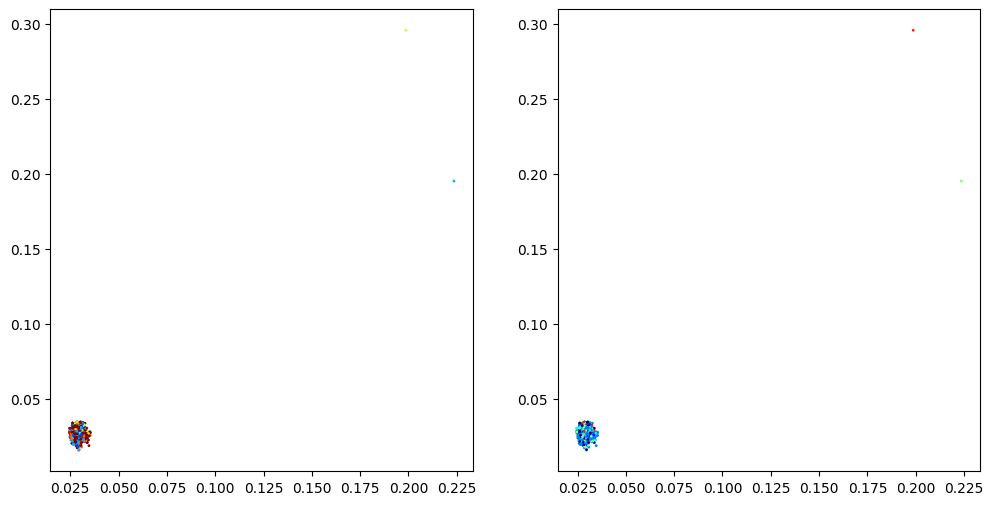

In [ ]:
plt.figure(figsize=(12, 6))

# Select the 0th feature: xs
xs = embeddings[:,0]
# Select the 1st feature: ys
ys = embeddings[:,1]

plt.subplot(1,2,1)
plt.scatter(xs,ys, c=list(maps['company']), s=1, cmap=plt.cm.jet)

plt.subplot(1,2,2)
plt.scatter(xs,ys, c=list(maps['position']), s=1, cmap=plt.cm.jet)
plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=30)
# reduced_embeddings = pca.fit_transform(embeddings)

# # Select the 0th feature: xs
# xs = reduced_embeddings[:,0]
# # Select the 1st feature: ys
# ys = reduced_embeddings[:,1]

# plt.subplot(1,2,1)
# plt.scatter(xs,ys, c=company_color_map, s=1, cmap=plt.cm.jet)

# plt.subplot(1,2,2)
# plt.scatter(xs,ys, c=position_color_map, s=1, cmap=plt.cm.jet)
# plt.show()

In [ ]:
tsne = TSNE(n_components=2,random_state=2023)
gnn_embeddings_tsne = tsne.fit_transform(embeddings)

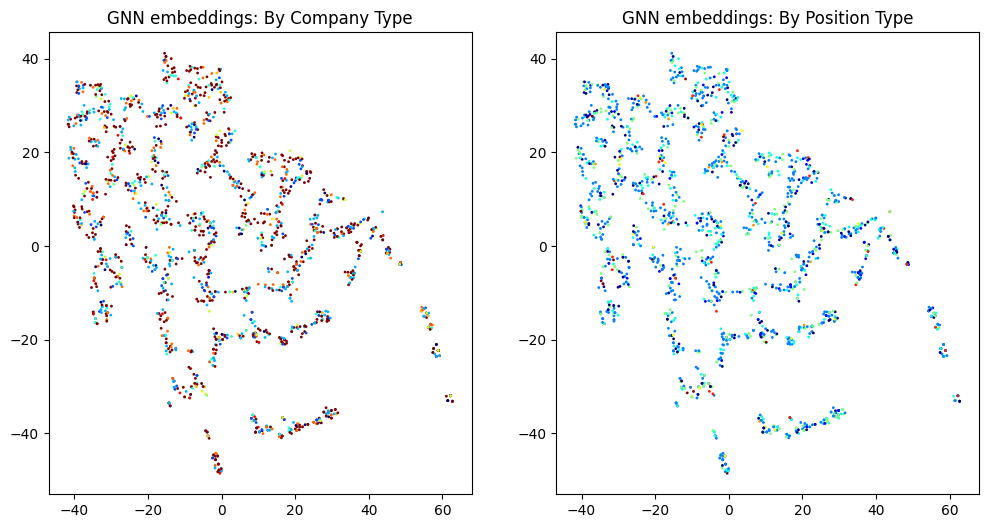

In [ ]:
plt.figure(figsize=(12, 6))

# Select the 0th feature: xs
xs = gnn_embeddings_tsne[:,0]
# Select the 1st feature: ys
ys = gnn_embeddings_tsne[:,1]

plt.subplot(1,2,1)
plt.scatter(xs,ys, c=list(maps['company']), s=1, cmap=plt.cm.jet)
plt.title('GNN embeddings: By Company Type')

plt.subplot(1,2,2)
plt.scatter(xs,ys, c=list(maps['position']), s=1, cmap=plt.cm.jet)
plt.title('GNN embeddings: By Position Type')
plt.show()

In [ ]:
gnn_embeddings_tsne.shape

(1698, 2)